![](../AnalysisDesigner/datafiles/cms.png)
 
# Start an Analysis in Experimental Particle Physics (3) 

## Part 3: Measure of the Z-boson mass and decay width.



#### Fitting the Z mass peak

Now you have selected in the [Tutorial 2.2](./Part2.ipynb), those pairs of muons compatibles with a Z-boson, you can perform a statistical analysis to measure the Z mass and decay width. 

All code you are going to need is provided in Analyzer_Package, so you can access it as many times as you need. We have implemented two different functions usually used for fitting the Z mass peak: a Gaussian and a Breit-Weigner. 

* [Gaussian](https://en.wikipedia.org/wiki/Normal_distribution) distribution:

$$ G(x;\mu,\sigma) = \dfrac{1}{\sqrt{2\pi}\sigma}\exp[-\dfrac{(x-\mu)^{2}}{2\sigma^{2}}]    $$

* [Relativistic Breit-Wigner](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution) distribution:

$$ B(m;M,\Gamma)= N * \dfrac{2}{\pi}*\dfrac{\Gamma^{2}M^{2}}{(m^{2}-M^{2})^{2} + m^{4}(\Gamma^{2}/M^{2})}   $$

To fit a generator-level Z peak a Breit-Wigner fit makes sense. However, reconstructed-level Z peaks have many detector resolutions that smear the Z mass peak. If the detector resolution is relatively poor, then it is usually good enough to fit a gaussian (since the gaussian detector resolution will overwhelm the inherent Briet-Wigner shape of the peak). If the detector resolution is fairly good, then another option is to fit a Breit-Wigner (for the inherent shape) convoluted with a gaussian (to describe the detector effects).This is in the "no-background" case. If you have backgrounds in your sample (Drell-Yan, cosmics, etc...), and you want to do the fit over a large mass range, then another function needs to be included to take care of this - an exponential is commonly used. 
 
**NOTE:** When you are using a python terminal, you need to import ROOT each time you run an exercise 


In [3]:
# Import ROOT
import ROOT

In [4]:
cd ~/work/CmsOpenData/AnalysisDesigner

/home/jovyan/CmsOpenData/AnalysisDesigner


### Gaussian Fit

Chi/NDF = 2.4784915887033003
Fit Probability = 0.0002551376536281259
 FCN=49.5698 FROM MIGRAD    STATUS=CONVERGED     102 CALLS         103 TOTAL
                     EDM=4.654e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.55464e+01   5.57596e+00  -3.08140e-03   4.27574e-06
   2  Mean         9.08595e+01   2.25420e-01   1.26713e-04   9.85401e-05
   3  Sigma        2.67855e+00   1.81443e-01  -2.04156e-06  -3.50111e-04


Info in <TCanvas::Print>: png file ../output_histograms/FitGaussfirstTry.png has been created


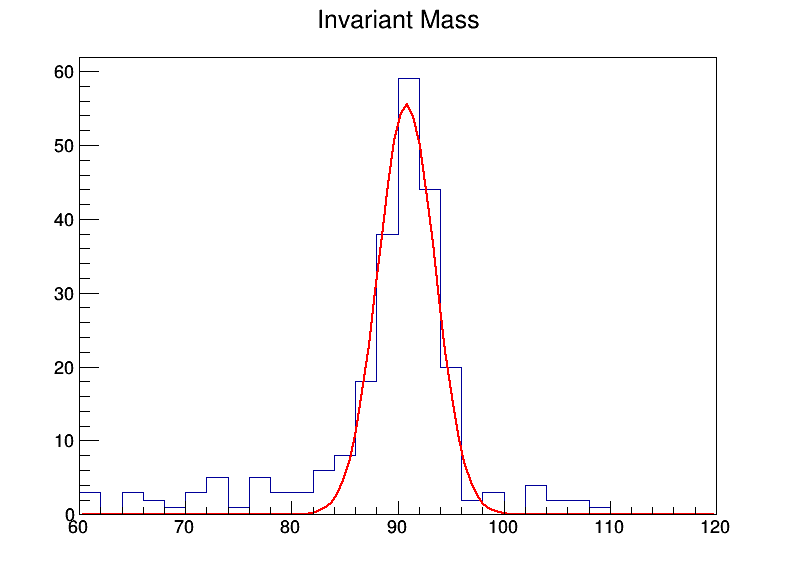

In [8]:
# Get the root file that contains the histograms for selected muons: goodHistos.root.
Gfile = ROOT.TFile("datafiles/goodhistos.root", "read")

### Then create again a new the canvas where the histograms are going to be drawn
canvas = ROOT.TCanvas("myCanvas","All muons: Pt",800,600)

histo6=Gfile.Get('h_mass')

histo6.GetXaxis().SetRangeUser(60, 120)


### One more time, draw the histogram
histo6.SetTitle("Invariant Mass")

f=ROOT.TF1("gauss","gaus",60,120)

histo6.Fit("gauss") #use the standard gauss function. 

print("Chi/NDF = {0}".format(f.GetChisquare() / f.GetNDF()))
print("Fit Probability = {0}".format(f.GetProb()))

#self.fit1 = self.gHisto.GetFunction("gaus")
from ROOT import gStyle
gStyle.SetOptFit(11111111)
histo6.Draw()
canvas.Draw()

name = "firstTry"
canvas.SaveAs("../output_histograms/FitGauss"+ name +".png")

### Breit Wigner

In [9]:
# Breit-Wigner function
def mybw(x, par):
    arg1 = 14.0/22.0 # 2 over pi
    arg2 = par[1]*par[1]*par[2]*par[2] #Gamma=par[1]  M=par[2] 
    arg3 = ((x[0]*x[0]) - (par[2]*par[2]))*((x[0]*x[0]) - (par[2]*par[2]))
    arg4 = x[0]*x[0]*x[0]*x[0]*((par[1]*par[1])/(par[2]*par[2]))
    return par[0]*arg1*arg2/(arg3 + arg4)

 
 ------ Results from Breit-Wigner Fit ------ 
 
 Chi2 / NDF:      1.569798403469589
 Fit Probability: 0.05017534593123312
 Mean:            90.91698991745622 +- 0.24462127881468043
 Gamma:           4.40404862928905 +- 0.045685403634148705


Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvas


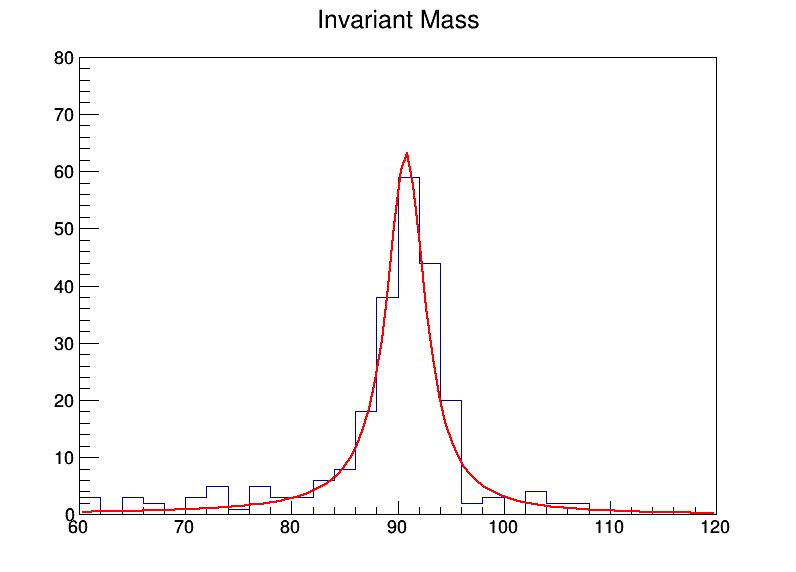

In [10]:
import math

gHisto=Gfile.Get('h_mass')

### Then create again a new the canvas where the histograms are going to be drawn
canvas = ROOT.TCanvas("myCanvas","All muons: Pt",800,600)
gHisto.Draw()
gHisto.GetXaxis().SetRangeUser(60, 120)
gHisto.GetYaxis().SetRangeUser(0, 80)

division = gHisto.GetNbinsX()
massMIN = gHisto.GetBinLowEdge(1)
massMAX = gHisto.GetBinLowEdge(division+1)
BIN_SIZE = gHisto.GetBinWidth(1)

from ROOT import gStyle, TF1
# Create a TF1 object for calling function mybw 
func = TF1("mybw",mybw,massMIN, massMAX,3)

# Set parameter start values for the function
func.SetParameter(0, 1)
func.SetParameter(2, 5)
func.SetParameter(1, 95)

gHisto.Fit("mybw","QR")

gStyle.SetOptFit()
func.Draw("same")

canvas.Draw()


## Printout fit results

chi2 = func.GetChisquare()
chi2_NDF = func.GetChisquare() / func.GetNDF()
prob = func.GetProb()
p1 = func.GetParameter(1)
e1 = func.GetParError(1)
p2 = func.GetParameter(2)
e2 = func.GetParError(2)

print(" ")
print(" ------ Results from Breit-Wigner Fit ------ ")
print(" ")
print(" Chi2 / NDF:      {0}".format(chi2_NDF))
print(" Fit Probability: {0}".format(prob))
print(" Mean:            {0} +- {1}".format(p2,e2))
print(" Gamma:           {0} +- {1}".format(p1,e1/(2*p1))) 


### Breit-Wigner convoluted with a Gaussian

Fit Output:
Z Boson Mass            =  90.81796384430872
Z Boson Width           =  3.220335705152856
Experimental Resolution =  1.3694882155343915
Overall Normalization   =  431.70589469905855

Normalized Chi2         =  1.6843795300094186
Fit Probability         =  0.03122867775835735
 FCN=32.0032 FROM MIGRAD    STATUS=CONVERGED     134 CALLS         135 TOTAL
                     EDM=3.16533e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Z mass       9.08180e+01   2.27522e-01   6.62287e-05  -6.02331e-05
   2  Experimental Resolution   1.36949e+00   4.80434e-01  -1.85227e-04   3.77742e-04
   3  Z Width      3.22034e+00   7.97292e-01  -2.14940e-04   2.17947e-04
   4  Overall Normalization   4.31706e+02   3.06373e+01  -8.75495e-03   1.07245e-07


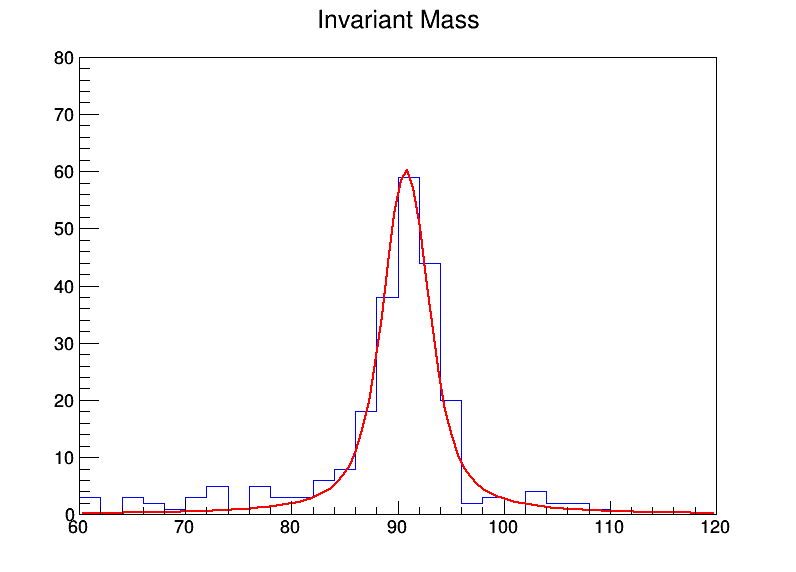

In [11]:
from ROOT import gROOT, TCanvas, TF1, TF1Convolution

myNewHisto=Gfile.Get('h_mass')

mathVoigt = TF1("mathVoigt","[3]*TMath::Voigt(x-[0],[1],[2],4)",0,200)

mathVoigt.SetParameter(0,myNewHisto.GetMean())
mathVoigt.SetParameter(1,myNewHisto.GetRMS())
mathVoigt.SetParameter(2,2.4)
mathVoigt.SetParameter(3,400)

mathVoigt.SetParName(0,"Z mass")
mathVoigt.SetParName(1,"Experimental Resolution")
mathVoigt.SetParName(2,"Z Width")
mathVoigt.SetParName(3,"Overall Normalization")

canvas3 = ROOT.TCanvas("Voigtian","Voigtian",800,600)

myNewHisto.SetLineColor(4)
myNewHisto.Draw()
myNewHisto.Fit("mathVoigt")

canvas3.Draw()

print("Fit Output:")
print("Z Boson Mass            = ", mathVoigt.GetParameter(0))
print("Z Boson Width           = ", mathVoigt.GetParameter(2))
print("Experimental Resolution = ", mathVoigt.GetParameter(1))
print("Overall Normalization   = ", mathVoigt.GetParameter(3))
print("")
print("Normalized Chi2         = ", mathVoigt.GetChisquare() / mathVoigt.GetNDF())
print("Fit Probability         = ", mathVoigt.GetProb())